# Bayesian Learning in a Linear Basis Function Model

In this notebook we ilustrate the bayesian learning in a linear basis function model, as well as the sequential update of a posterior distribution.

Taken from Christopher Bishop's Pattern Recognition and Machine Learning book (p.155)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from numpy.random import seed, uniform, randn
from numpy.linalg import inv

In [3]:
%config InlineBackend.figure_format = "retina"

We consider an input $x$, a target variable $t$ and a linear model of the form
$$
    y(x, {\bf w}) = w_0 + w_1x
$$

In [4]:
def f(x, a): return a[0] + a[1] * x

In [5]:
seed(314)
a = np.array([-0.3, 0.5])
N = 30
sigma = 0.2
X = uniform(-1, 1, (N, 1))
T = f(X, a) + randn(N, 1) * sigma

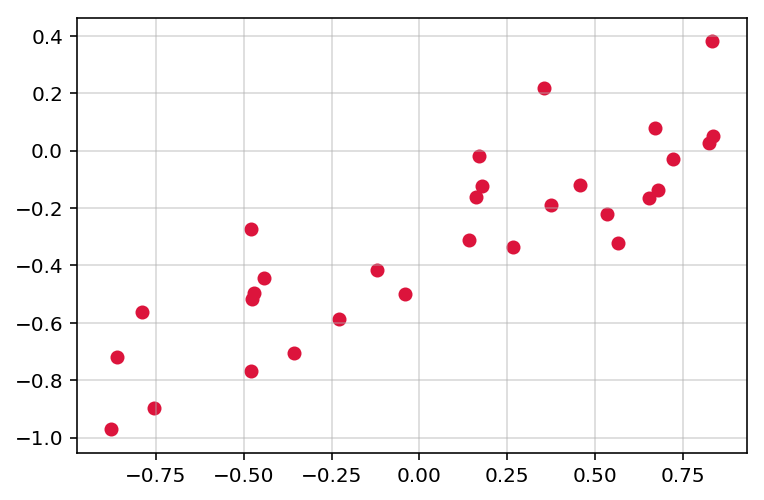

In [6]:
plt.scatter(X, T, c="crimson")
plt.grid(alpha=0.5)

Our goal is to recover the values $w_0$ and $w_1$ from the data.

Recall:
$$
    p({\textbf w}|t) \propto p(t| {\textbf w}, \beta) p(\bf{w})
$$

In [7]:
beta = (1 / sigma) ** 2 # precision
alpha = 2.0

* $t \sim \mathcal{N}\left({\bf w}^Tx, \beta^{-1}\right)$ (The assigned probability for target variables)

The posterior distribution of $\bf w$ after $N$ observations is given by

$$
\begin{align}
    m_N &= S_N(S_0^{-1}m_0 + \beta\Phi^T{\bf t}) \\
    S_N^{-1} &= S_0^{-1} + \beta\Phi^T\Phi
\end{align}
$$

With
* $\Phi\in\mathbb{R}^{N\times M}$
* ${\bf t}\in\mathbb{R}^N$

If no data has been yet seen, we consider
$$
w \sim \mathcal{N}\left(0, \alpha^{-1}\text{I}\right)
$$
Which results in a posterior distribution of the form

$$
\begin{align}
    m_N &= \beta S_N\Phi^T{\bf t} \\
    S_N^{-1} &= \alpha \text{I} + \beta\Phi^T\Phi
\end{align}
$$

In [116]:
def posterior_w(phi, t, S0, m0):
    """
    Compute the posterior distribution of 
    a Gaussian with known precision and conjugate
    prior a gaussian
    
    Parameters
    ----------
    phi: np.array(N, M)
    t: np.array(N, 1)
    S0: np.array(M, M)
        The prior covariance matrix
    m0: np.array(M, 1)
        The prior mean vector
    """
    SN = inv(inv(S0) + beta * Phi.T @ Phi)
    mN = SN @ (inv(S0) @ m0 + beta * Phi.T @ t)
    return SN, mN

def sample_vals(X, T, ix):
    """
    
    Returns
    -------
    Phi: The linear model transormation
    t: the target datapoint
    """
    x_in = X[ix]
    Phi = np.c_[np.ones_like(x_in), x_in]
    t = T[[ix]]
    return Phi, t

def plot_prior(m, S, liminf=-1, limsup=1, step=0.05, ax=None, **kwargs):
    grid = np.mgrid[liminf:limsup + step:step, liminf:limsup + step:step]
    nx = grid.shape[-1]
    z = multivariate_normal.pdf(grid.T.reshape(-1, 2), mean=m.ravel(), cov=S).reshape(nx, nx).T
    
    return ax.contourf(*grid, z, **kwargs) if ax is not None else plt.contourf(*grid, z, **kwargs)

def plot_sample_w(mean, cov, size=10, ax=plt):
    w = np.random.multivariate_normal(mean=mean.ravel(), cov=cov, size=size)
    x = np.linspace(-1, 1)
    for wi in w:
        ax.plot(x, f(x, wi), c="tab:blue", alpha=0.4)
        
def plot_likelihood_obs(X, T, ix, ax=plt):
    """
    Plot the likelihood function of a single observation
    """
    W = np.mgrid[-1:1:0.1, -1:1:0.1]
    x, t = sample_vals(X, T, ix)
    mean = W.T.reshape(-1, 2) @ x.T

    likelihood = norm.pdf(t, loc=mean, scale= np.sqrt(1 / beta)).reshape(20, 20).T
    ax.contourf(*W, likelihood)
    ax.scatter(-0.3, 0.5, c="white", marker="+")

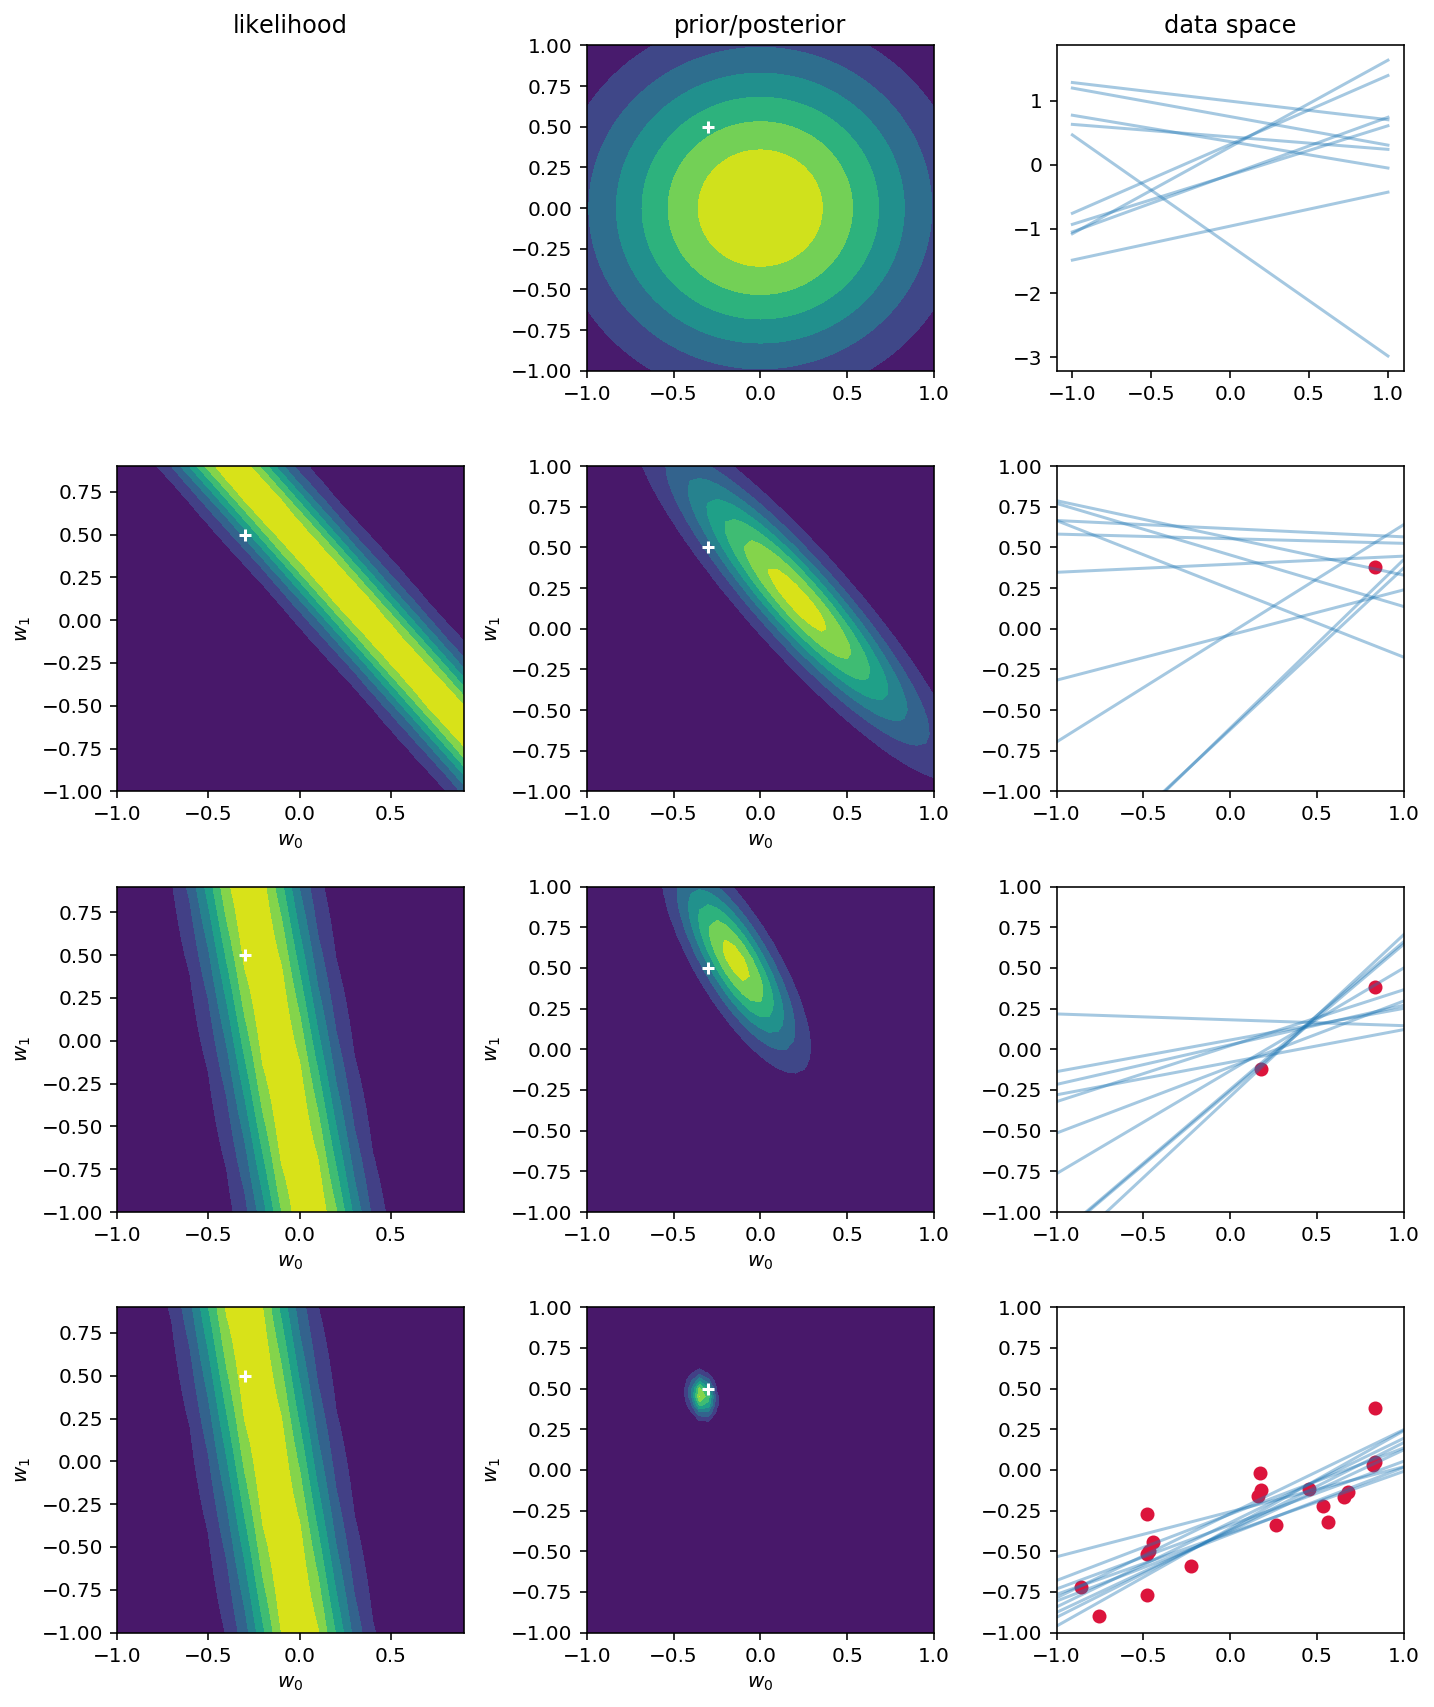

In [123]:
SN = np.eye(2) / alpha
mN = np.zeros((2, 1))

seed(1643)
N = 20
nobs = [1, 2, 20]
ix_fig = 1
fig, ax = plt.subplots(len(nobs) + 1, 3, figsize=(10, 12))
plot_prior(mN, SN, ax=ax[0,1])
ax[0, 1].scatter(-0.3, 0.5, c="white", marker="+")
ax[0, 0].axis("off")
plot_sample_w(mN, SN, ax=ax[0, 2])
for i in range(0, N+1):
    Phi, t = sample_vals(X, T, i)
    SN, mN = posterior_w(Phi, t, SN, mN)
    if i+1 in nobs:
        plot_likelihood_obs(X, T, i, ax=ax[ix_fig, 0])
        plot_prior(mN, SN, ax=ax[ix_fig, 1])
        ax[ix_fig, 1].scatter(-0.3, 0.5, c="white", marker="+")
        ax[ix_fig, 2].scatter(X[:i + 1], T[:i + 1], c="crimson")
        ax[ix_fig, 2].set_xlim(-1, 1)
        ax[ix_fig, 2].set_ylim(-1, 1)
        for l in range(2):
            ax[ix_fig, l].set_xlabel("$w_0$")
            ax[ix_fig, l].set_ylabel("$w_1$")
        plot_sample_w(mN, SN, ax=ax[ix_fig, 2])
        ix_fig += 1

titles = ["likelihood", "prior/posterior", "data space"]
for axi, title in zip(ax[0], titles):
    axi.set_title(title)
plt.tight_layout()